In [1]:
# auto reload

%load_ext autoreload
%autoreload 2

In [2]:
from dsd import DATA_DIR
from dsd.diffusion_rendering import * 




/home/tlips/.conda/envs/dsd/lib/python3.10/site-packages/controlnet_aux/mediapipe_face/mediapipe_face_common.py:7: UserWarning: The module 'mediapipe' is not installed. The package will have limited functionality. Please install it using the command: pip install 'mediapipe'
  warnings.warn(
/home/tlips/.conda/envs/dsd/lib/python3.10/site-packages/controlnet_aux/segment_anything/modeling/tiny_vit_sam.py:654: UserWarning: Overwriting tiny_vit_5m_224 in registry with controlnet_aux.segment_anything.modeling.tiny_vit_sam.tiny_vit_5m_224. This is because the name being registered conflicts with an existing name. Please check if this is not expected.
  return register_model(fn_wrapper)
/home/tlips/.conda/envs/dsd/lib/python3.10/site-packages/controlnet_aux/segment_anything/modeling/tiny_vit_sam.py:654: UserWarning: Overwriting tiny_vit_11m_224 in registry with controlnet_aux.segment_anything.modeling.tiny_vit_sam.tiny_vit_11m_224. This is because the name being registered conflicts with an e

In [3]:
image_dir =  "mug"
input_images = DiffusionRenderInputImages.from_render_dir(image_dir)
#input_images.depth_image[input_images.depth_image > 1.0] = 1.0


Text(0.5, 1.0, 'Depth')

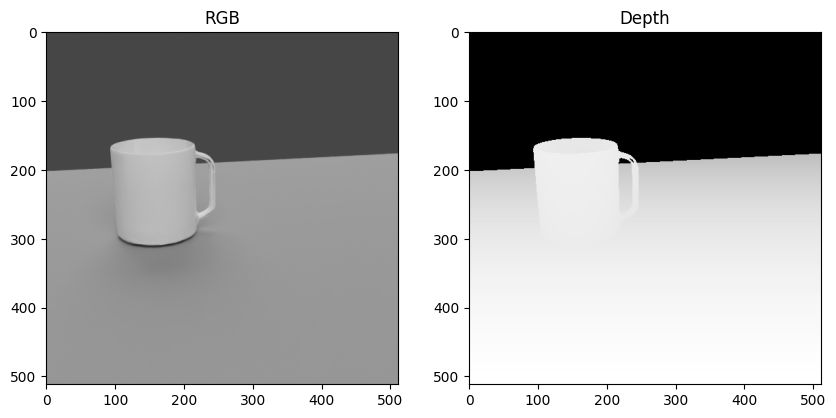

In [4]:
# plot original image and depth, as well as the processed images 
import matplotlib.pyplot as plt
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
axes[0].imshow(input_images.rgb_image)
axes[0].set_title("RGB")
axes[1].imshow(input_images.get_inverted_depth_image(), cmap="gray")
axes[1].set_title("Depth")


In [5]:
one_stage_renderer = ControlNetTXTFromDepthRenderer(1)

/home/tlips/.conda/envs/dsd/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

/home/tlips/.conda/envs/dsd/lib/python3.10/site-packages/diffusers/utils/outputs.py:63: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  torch.utils._pytree._register_pytree_node(


In [6]:
mug_prompt = " red mug with a colorful pixel art character"
table_prompt = "blue wooden table with a modern, minimalist look"

In [7]:
torch.random.manual_seed(2025)
one_stage_images = one_stage_renderer(f"{mug_prompt} on a {table_prompt}", input_images)

  0%|          | 0/50 [00:00<?, ?it/s]

/home/tlips/.conda/envs/dsd/lib/python3.10/site-packages/torch/nn/modules/conv.py:456: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at /home/conda/feedstock_root/build_artifacts/libtorch_1716579264291/work/aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return F.conv2d(input, weight, bias, self.stride,


Text(0.5, 1.0, 'Depth')

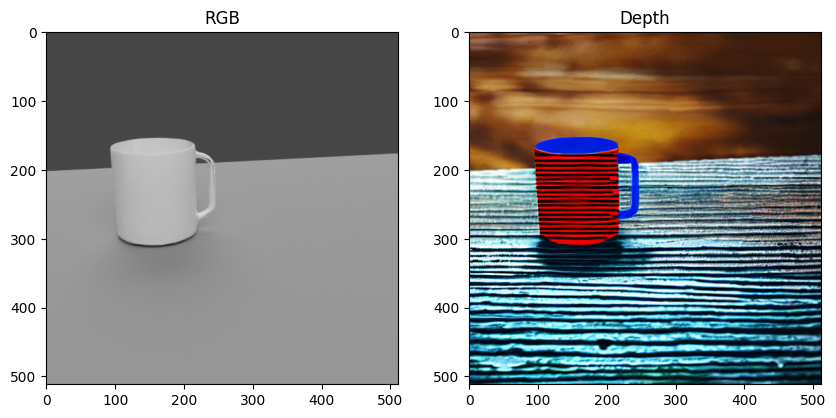

In [8]:
# visualize the image
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
axes[0].imshow(input_images.rgb_image)
axes[0].set_title("RGB")
axes[1].imshow(one_stage_images[0])
axes[1].set_title("Depth")



In [9]:
# create a two stage renderer

from dsd.cropped_diffusion_rendering import CropAndInpaintRenderer, CroppedRenderer

two_stage_renderer = CropAndInpaintRenderer(
    crop_renderer=CroppedRenderer(
        renderer=one_stage_renderer,
        bbox_padding=10,
        only_change_mask=True),
    inpainter=SD2InpaintingRenderer(num_images_per_prompt=1),
    mask_dilation_iterations=3
)

/home/tlips/.conda/envs/dsd/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

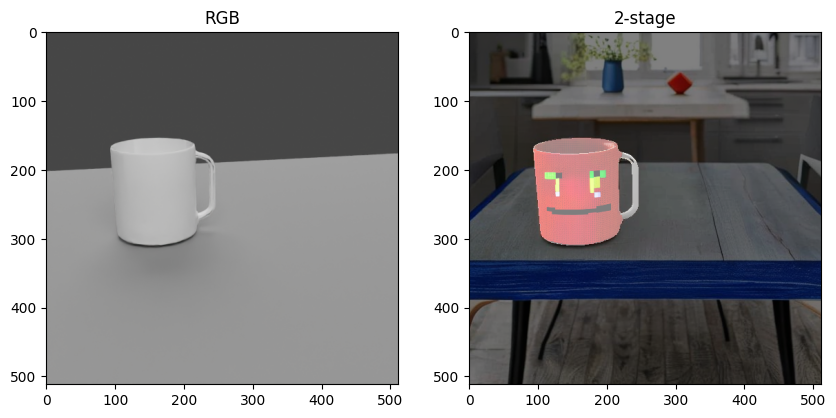

In [53]:
# get two stage image

torch.random.manual_seed(2027)
two_stage_image = two_stage_renderer(mug_prompt,table_prompt,input_images)

# visualize the image
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
axes[0].imshow(input_images.rgb_image)
axes[0].set_title("RGB")
axes[1].imshow(two_stage_image[0])
axes[1].set_title("2-stage")

# overlay the mask
mask = input_images.mask
axes[1].imshow(mask, alpha=0.5, cmap="gray")




In [11]:
from dsd.three_stage_diffusion_rendering import ThreeStageRenderer

In [12]:
three_stage_renderer = ThreeStageRenderer(
    background_renderer=two_stage_renderer,
    object_renderer=CroppedRenderer(one_stage_renderer),
)



In [13]:
table_input_images = DiffusionRenderInputImages.from_render_dir("mug/table_only")

In [19]:
torch.random.manual_seed(2021)

three_stage_images = three_stage_renderer(input_images,table_input_images,mug_prompt,table_prompt)

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Text(0.5, 1.0, '3-stage')

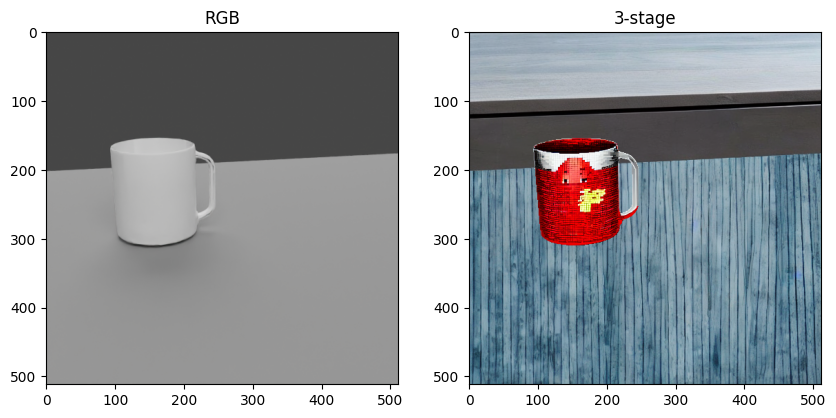

In [20]:
# visualize the image
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
axes[0].imshow(input_images.rgb_image)
axes[0].set_title("RGB")
axes[1].imshow(three_stage_images[0])
axes[1].set_title("3-stage")

In [44]:
# save one-stage and three-stage image
from PIL import Image
img = input_images.rgb_image
img = Image.fromarray((img * 255).astype(np.uint8))
img.save("mug_scene.png")
one_stage_images[0].save("mug_one_stage.png")
three_stage_images[0].save("mug_three_stage.png")

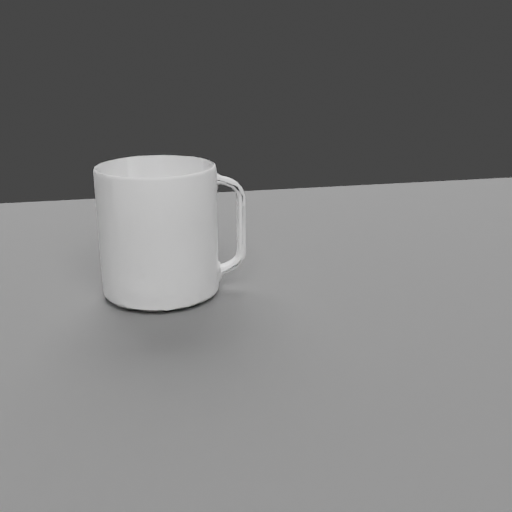

In [43]:
img